# Hito 3
### Grupo 7

## Introducción

### Contexto

Steam es una aplicación multi-plataforma de distribución digital de videojuegos u otras aplicaciones, la cual fue pionera en este rubro, logrando en 17 años tener hasta 25 millones de usuarios simultáneos, con una librería total de 51,962 juegos hasta la fecha (08/04/2021). Este gran éxito se debe a los servicios que ofrece, pues Steam no solo protege de la piratería, si no que también permite la centralización de la industria en PC, proporciona servidores de emparejamiento, para así jugar de forma online; y consta de un sistema de red social, en la cual la comunidad además de crear modificaciones para los juegos, puede discutir sobre estos, lo que se complementa muy bien con la tienda que tiene la misma, creando así un sistema de reviews en donde los usuarios dan su opinión respecto a un juego.


### Motivación

A partir de esto, la motivación del estudio en particular de estas bases de datos surge de la premisa anteriormente mencionada y sobre la cual existe una gran cantidad de usuarios de Steam a nivel mundial, sumado al efecto generado producto de la pandemia, en donde esta plataforma y en general la industria de los juegos, tuvieron un crecimiento considerable. Por otro lado, se considera que tanto los datos como las predicciones y caracterizaciones de usuario generadas desde esta plataforma, pueden ser extensibles a otros medios debido a las similitudes entre las industrias. Finalmente, se buscará encontrar algún factor que permita objetivar las reviews de estos y poder generar predicciones con estas, las cuales se detallarán en la sección de Preguntas y Problemas.


## Exploración de Datos

* Para este estudio, se trabajarán 3 bases de datos ([Reviews de Steam](https://www.kaggle.com/najzeko/steam-reviews-2021), [Juegos y aplicaciones de Steam](https://www.kaggle.com/trolukovich/steam-games-complete-dataset) y Listado de Amigos de Steam(la cual fue creada en base a la de [Reviews de Steam](https://www.kaggle.com/najzeko/steam-reviews-2021))), la primera presenta las reviews realizadas por usuarios de la plataforma steam a los distintos juegos presentes en esta, mientras que el segundo dataset corresponde a una categorización de los juegos. Por otro lado el tercer dataset fue generado a partir de la `API de Steam` y contiene la lista de amigos asociada a cada jugador.

* Es posible observar que el primer dataset completo contiene un total de 21.747.371 datos, de los cuales, en este estudio se centrara solo en los datos categorizados por el idioma Ingles.




A continuación se adjuntan las librerias Usadas en este estudio:

### Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import TextBlob, Word, Blobber
from multiprocessing import Pool
import tqdm
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Creación de la base de datos de amigos en Steam.

Para poder crear esta abse de datos, se escribieron y ejecutaron las siguientes lineas de codigo.

```python
API_KEY = "(key de nuestro usuario de Steam)"

# Cargamos la base de datos de reseñas
reviews = pd.read_csv("/content/drive/MyDrive/Minería/Dataset/steam_reviews_english.csv",
 encoding = "ISO-8859-1")

# Filtramos la base de datos de reseñas a solo los steamid de los usuarios
reviews_filter = reviews[["author.steamid"]]
reviews_filter = reviews_filter.drop_duplicates()

# Acá se hacen los GET request paralelizados, ya que si se hacian uno por uno se demoraba demasiado
db = reviews_filter["author.steamid"]
total_tasks = db.shape[0]
po = 150
def get_data(i):
    # Se cambia el formato del steam id para que not enga decimales
    out = "{:.0f}".format(i)
    # URL de la API en donde hacemos los request
    URL = "https://api.steampowered.com/ISteamUser/GetFriendList/v1/"
    # Parametros del request
    PARAMS = {'key': API_KEY,
             'steamid': out}
    r = requests.get(url = URL, params = PARAMS)

    # Aquí verificamos que la request fue exitosa
    if str(r) == "<Response [200]>":
        data = r.json()
        df = pd.json_normalize(data["friendslist"]["friends"])
        df["user_id"] = [float(out)] * len(df)
        df = df.rename(columns={"steamid": "friend_id"})
        return df
    else:
        return pd.DataFrame()

# Creación de los Treads
if __name__ == '__main__':
    with Pool(po) as p:
        data_list = list(tqdm.tqdm(p.imap(get_data, db), total=total_tasks, position=0))


# Acá se eliminan los datasets que quedaron con 0 amigos
i = 0
while(i<len(data_list)):
  a = data_list[i].shape[0]
  if a == 0:
    data_list.pop(i)
  else:
    i+=1   


# Se particiona la data_list en sub-listas, que contiene una lista de dataset's que son los resultados de las requests
chunks = [data_list[x:x+1000] for x in range(0, len(data_list), 1000)]


# Paralelizamos nuevamente el proceso, esta vez es la union de los datasets de resultado, ya que hacerlo uno por uno tardaba demasiado.
total_tasks = len(chunks)
po = 50 #150

def ap_list(data):
    # Se unen los DataFrames en uno vacío
    friends_db = pd.DataFrame()
    for i in data:
        friends_db = friends_db.append(i)
    return friends_db

# Creación de los Treads
if __name__ == '__main__':
    iterable = chunks
    with Pool(po) as p:
        data_list_2 = list(tqdm.tqdm(p.imap(ap_list, iterable), total=total_tasks, position=0))

# Similar a la parte anterior, se unen los resultados del data_list_2.
friends_db = pd.DataFrame()
for j in tqdm.tqdm(data_list_2):
    friends_db = friends_db.append(j)

# Se actualizan los id de la friends_db
friends_db = friends_db.reset_index(drop=True)

# Se exporta la base a csv
friends_db.to_csv("/content/drive/MyDrive/Minería/Dataset/steam_friendsv2.csv", index=False)
```

### Carga y limpieza de datos

Es importante destacar que dado el tamaño presenten en la base de datos que contienen las reviews a modo de preprocesamiento se realizo una limpieza de los datos.
Se eliminan los outliers que ensucian los datos del dataset, para ello se comparan las medias entre las variables numéricas (utilizando todos los datos) con la media de estas variables sin el 1% de los datos, a partir de los percentiles, se estudia además, el porcentaje de datos que está bajo un número determinado, notando principalmente que en algunos casos, el 1% de los datos son extremadamente grandes en comparación al 99% de los datos restantes, por lo que son eliminados.

### Matriz de Correlación

Con el fin de estudiar las relaciones entre las variables numéricas, se realiza una matriz de correlación.

![picture](https://drive.google.com/uc?export=view&id=1JfXL1mkuH9L-cfaNNhGDSJ3wF-pODlHC)


De esta matriz se pueden identificar algunas correlaciones interesantes, además de las esperadas, como por ejemplo entre el total tiempo jugado y el tiempo jugado al hacer la review, lo que implica que los usuarios generalmente hacen reseñas serias, pues toman el tiempo adecuado, o por lo menos en proporción a la cantidad total que jugaron, para dar su opinión. Otro resultado a considerar es la relación negativa que existe entre los juegos que tiene un usuario en su biblioteca y el tiempo jugado al momento de la review, siendo así los jugadores con más experiencia los más veloces en emitir algún tipo de juicio sobre dicho juego.

También se puede comprobar algunas relaciones que por definición de variables deben estar, lo que asegura la calidad del dataset, como la relación entre el peso del voto (ponderación de votos “útil” y “no útil”) con la cantidad de votos “útil”

### Gráficos

A continuación se realizarán algunos gráficos para poder estudiar, analizar y comprender, algunas comparaciones y tendencias de los datos.


![picture](https://drive.google.com/uc?export=view&id=1E9zFuWkHIrrz4naxEQwpHlFWIyOamgjP)

Este gráfico muestra claramente la tendencia de los usuarios, de realizar pocas reviews, pues alrededor de 6 millones de usuarios solo realizaron una, luego 2 millones tuvieron dos y solo un millón hicieron tres.

![picture](https://drive.google.com/uc?export=view&id=1CSDeCxQpqEXPL3yjpr9igjEr9fq_iOUo)

Al observar el crecimiento de reviews por año se pude observar claramente el efecto producido por la pandemia, pues a pesar de que la plataforma el año 2019 manifiesta una gran cantidad de reseñas, con una gran diferencia con respecto al año anterior, en el 2020 la cantidad de reseñas llega a aproximadamente el doble que el 2019, siendo por lejos el año con mayor crecimiento para steam.

Para los siguientes dos análisis no solo se utilizarán los datos globales, si no que también se observarán los mismos gráficos para cada uno de los 4 idiomas principales, con el fin de comprobar las similitudes o diferencias entre cada uno de los usuarios y sus lenguas y zonas.


![picture](https://drive.google.com/uc?export=view&id=1TFa7lBKCN3KEktB2DWqdq9AJZaKtwHJ1)

Se puede visualizar que el año 2020 es en el cual se realizaron más reviews para cada juego, a excepción de
`PLAYERUNKNOW’S BATTLEGROUNDS`, cuya mayor cantidad de reviews fueron realizadas en 2017, que es el primer año en que hubo una cantidad significativa de reseñas.

![picture](https://drive.google.com/uc?export=view&id=13_K1TvnrPrIJXAO9E00K9iloYJXcagwF)

Como primera observación es evidente que el `PLAYERUNKNOW’S BATTLEGROUNDS`, a pesar de figurar en el top está muy mal evaluado, y de esta forma no se puede ver una correlación entre la cantidad de reviews y la recomendación de un juego. También se ve que, aproximadamente la mitad de los juegos que sale en el top tiene una buena recomendación, y la otra mitad varía más en valores más bajos.

### Text-Mining map para inglés

Se realizo un filtro para las reviews que están en inglés, además, se utilizo una muestra aleatoria de 10000 reseñas presentes en la sub database filtrada al inglés.

![picture](https://drive.google.com/uc?export=view&id=1xhNRYlppbWdPtO3bNzw8BMkLQPJcfCwP)


De este text-mining map resaltan palabras como “hours”, “time” y “story”. Lo que se puede interpretar es tanto la importancia que le dan los usuarios a las características como el tiempo que se puede jugar el juego sin parecer monótono, la calidad de la historia, y la re-jugabilidad de este.

Durante la investigación surgen las siguientes preguntas, que impulsan y guían esta, de las cuales en algunas se acercan a sus posibles respuestas, y otras se espera algún acercamiento mayor en lo que resta del curso.

Para complementar la base de datos utilizada en el hito anterior se agregó una nueva más orientada a los usuarios en sí mismos, la cual contiene información como la id de cada cuenta, timestamp de agregación de amigos/amigas, de la realización de su primera review, etc. Lo cual permite la extensión de la hipótesis inicial, las posibles preguntas a responder con mayor rigurosidad, e incluso una experimentación con los datos para permitir la realización de predicciones  los cuales se verán en la sección de Preguntas y Problemas, y Propuesta Experimental, respectivamente.

A continuación se importa la base de datos que contiene la lista de amigos.

In [ ]:
#style.use('dark_background')
pd.set_option('display.float_format', lambda x: '%.1f' % x)

friends = pd.read_csv('/content/drive/MyDrive/Minería/Dataset/steam_friendsv2.csv')
friends.columns = ['friend_id', 	'relationship', 	'friend_since', 	'author_steamid']
friends

,friend_id,relationship,friend_since,author_steamid
0,76561197970536303,friend,1595123193,76561198065591520.0
1,76561198057129849,friend,1521865667,76561198065591520.0
2,76561198063221422,friend,1345071159,76561198065591520.0
3,76561198075737818,friend,1354233109,76561198065591520.0
4,76561198077177730,friend,1360805612,76561198065591520.0
...,...,...,...,...
23476252,76561199003342342,friend,1589497634,76561198073166960.0
23476253,76561199042437340,friend,1588445901,76561198073166960.0
23476254,76561199053414237,friend,1588447892,76561198073166960.0
23476255,76561199062544327,friend,1590931546,76561198073166960.0


Cantidad de amigos por usuario

In [ ]:
df = friends.groupby('author_steamid')['friend_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
df.columns = ['author_steamid','Cantidad_amigos']
df

,author_steamid,Cantidad_amigos
0,76561198996000384.0,1998
1,76561198362721536.0,1960
2,76561198099693552.0,1866
3,76561198219108544.0,1741
4,76561198131877760.0,1523
...,...,...
1106284,76561199051049040.0,1
1106285,76561199013172592.0,1
1106286,76561198041117504.0,1
1106287,76561198314134112.0,1


Cantidad de usuarios que tienen una X cantidad de amigos

In [ ]:
df2 = df.groupby('Cantidad_amigos')['author_steamid'].nunique().sort_values(ascending=False).to_frame().reset_index()
df2.columns = ['Cantidad_amigos', 'Cantidad_users']
df2

,Cantidad_amigos,Cantidad_users
0,1,247682
1,2,116787
2,3,74990
3,4,55836
4,5,43652
...,...,...
679,630,1
680,631,1
681,632,1
682,634,1


In [ ]:
df3 = df2["Cantidad_users"]/sum(df2["Cantidad_users"])*100
df4 = pd.DataFrame(df3)
df4.columns = ['%Users']
df4[df4['%Users'] >= 1]

,%Users
0,22.4
1,10.6
2,6.8
3,5.0
4,3.9
5,3.3
6,2.8
7,2.4
8,2.2
9,1.9


Tabla que muestra cuantos usuarios tienen una X cantidad de amigos y el porcentaje de la base que corresponde a eso (% de usuarios con esa cantidad de amigos)

In [ ]:
user = pd.DataFrame(df2["Cantidad_users"])
fri= pd.DataFrame(df2['Cantidad_amigos'])
porc = pd.DataFrame(df4["%Users"])
base2 = pd.concat([fri, user, porc], axis = 1)
base2.head(5)

,Cantidad_amigos,Cantidad_users,%Users
0,1,247682,22.4
1,2,116787,10.6
2,3,74990,6.8
3,4,55836,5.0
4,5,43652,3.9


Grafico que muestra cuantos usuarios tienen una cierta cantidad de amigos.

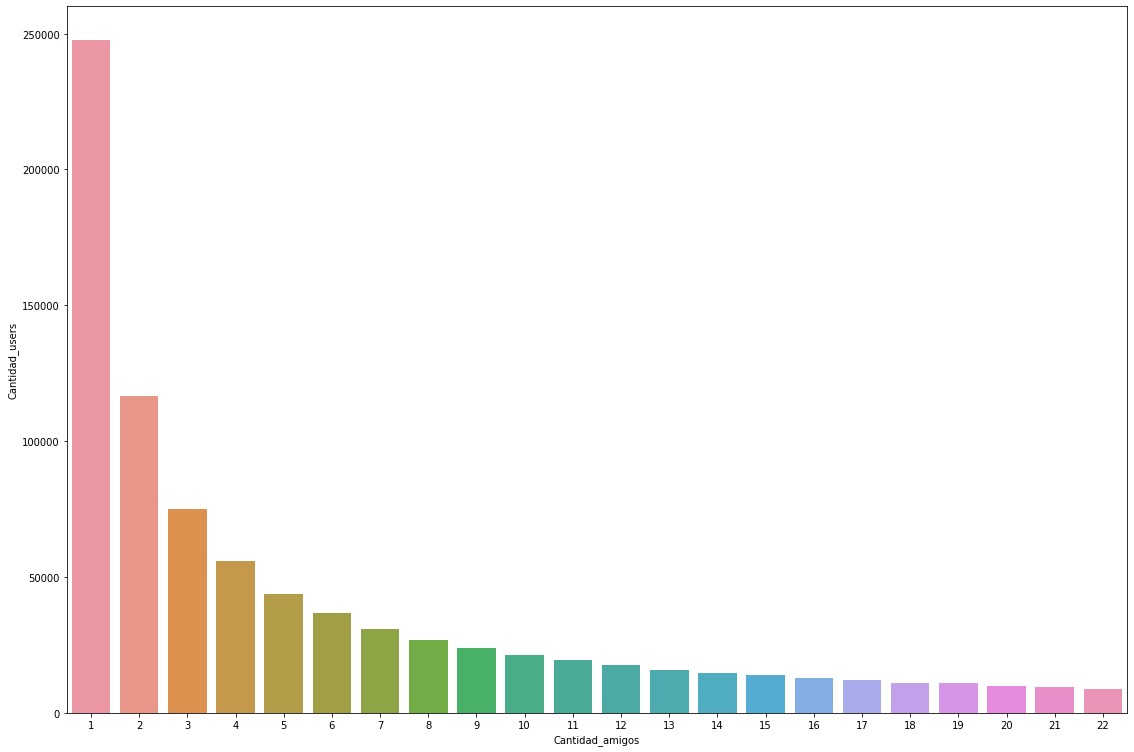

In [ ]:
base3 = base2.iloc[0:22,:]
fig, ax = plt.subplots(figsize = (19, 13))
sns.barplot(x="Cantidad_amigos", y="Cantidad_users", data=base3, ax = ax)

A continuación se busca estudiar, a aquellos usuarios que tienen más amigos y que porcentaje representan en la base.

In [ ]:
user = pd.DataFrame(df2["Cantidad_users"])
fri= pd.DataFrame(df2['Cantidad_amigos'])
porc = pd.DataFrame(df4["%Users"])
base2 = pd.concat([fri, user, porc], axis = 1)
base4 = base2.iloc[22:,:]
base4

,Cantidad_amigos,Cantidad_users,%Users
22,23,8423,0.8
23,24,8112,0.7
24,25,7739,0.7
25,26,7423,0.7
26,27,7038,0.6
...,...,...,...
679,630,1,0.0
680,631,1,0.0
681,632,1,0.0
682,634,1,0.0


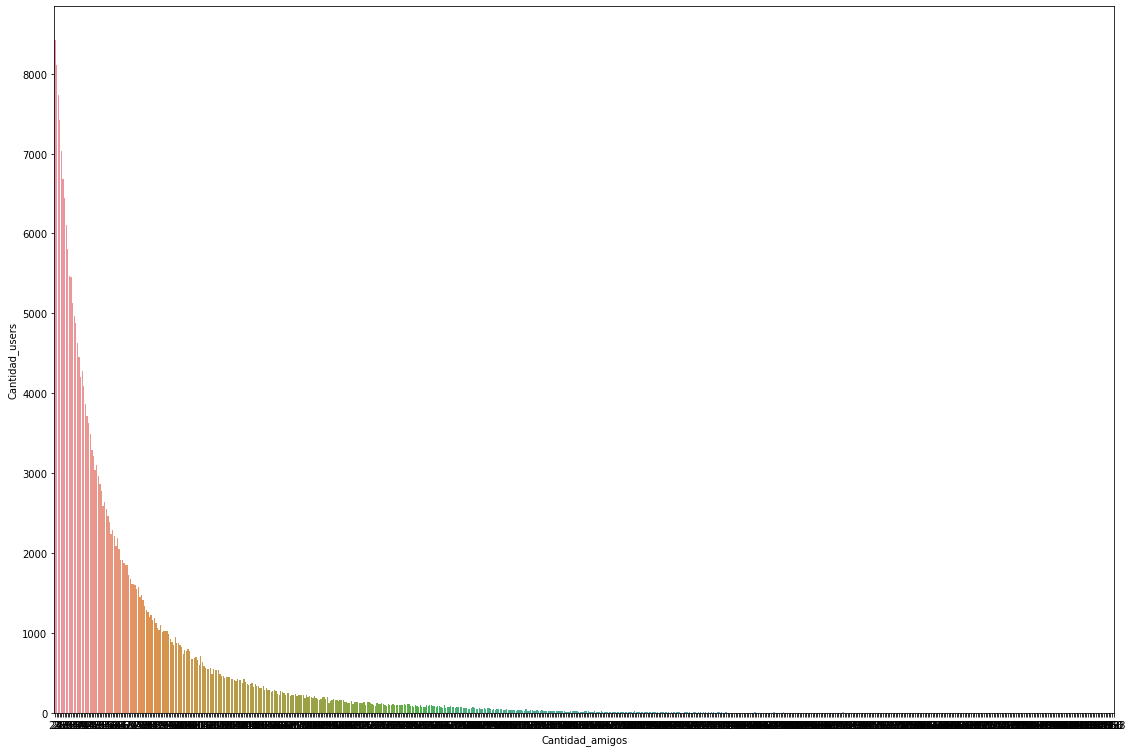

In [ ]:
fig, ax = plt.subplots(figsize = (19, 13))
sns.barplot(x="Cantidad_amigos", y="Cantidad_users", data=base4, ax = ax)

Acá se puede notar una tendencia `exponencial negativa` a la cantidad de amigos que tiene un usuario. Viendo así que la mayor cantidad de usuarios van a tender a tener pocos amigos.


En lo que sigue se filtrarán a las personas que tienen más de 1 amigo, puesto que no queremos reviews de personas sin amigos agregados, puesto que podrían representar perfiles falsos u bots.

In [ ]:
dff = df[df['Cantidad_amigos'] > 1]
dff.head(3)

,author_steamid,Cantidad_amigos
0,76561198996000384.0,1998
1,76561198362721536.0,1960
2,76561198099693552.0,1866


Se carga la base que contienen las reviews realizadas exclusivamente en idioma `Ingles`.


In [ ]:
eng = pd.read_csv("/content/drive/MyDrive/Minería/Dataset/steam_reviews_english.csv", encoding='ISO-8859-1')
eng.head(3)

,X1,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,3.0,292030,The Witcher 3: Wild Hunt,85184605.0,english,"One of the best RPG's of all time, worthy of a...",1611379970.0,1611379970.0,True,0,0,0.0,0,True,False,False,76561199054755376.0,5,3,5587.0,3200.0,5524.0,1611383744.0
1,5.0,292030,The Witcher 3: Wild Hunt,85184171.0,english,"good story, good graphics. lots to do.",1611379264.0,1611379264.0,True,0,0,0.0,0,True,False,False,76561198170193536.0,11,1,823.0,823.0,823.0,1611379201.0
2,6.0,292030,The Witcher 3: Wild Hunt,85184064.0,english,"dis gud,",1611379091.0,1611379091.0,True,0,0,0.0,0,True,False,False,76561198119302816.0,27,2,4192.0,3398.0,4192.0,1611351734.0


Aprovechamos de hacer una limpieza de la base de datos eliminando lo que serían reviews duplicadas.

In [ ]:
eng.drop_duplicates(inplace=True)
eng.shape

(9635437, 23)

Se observan los NA'S, dado que existen datos faltantes de la columna "review", se eliminan las filas, ya que no tiene sentido no tener reseñas en un analisis de reiews

In [ ]:
eng.isnull().sum()
eng = eng[eng['review'].notna()]

In [ ]:
eng.columns = ['X1', 'app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author_steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played']

Ahora que se tienen ambas bases filtradas y limpias, se procede a unirlas para conseguir un `dataset` más completo.

In [ ]:
base = pd.merge(eng,dff, on='author_steamid' )
base.head(3)

,X1,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,Cantidad_amigos
0,18.0,292030,The Witcher 3: Wild Hunt,85180436.0,english,favorite game of all time cant wait for the Ne...,1611373086.0,1611373086.0,True,0,0,0.0,0,True,False,False,76561198065591520.0,33,1,23329.0,177.0,23329.0,1611219011.0,16
1,14439707.0,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,52608868.0,english,THIS GAME GAVE ME THE CHILLS,1561928770.0,1561928770.0,True,0,0,0.0,0,True,False,False,76561198065591520.0,67,9,12938.0,0.0,10518.0,1571965506.0,16
2,46.0,292030,The Witcher 3: Wild Hunt,85172769.0,english,"We all know you'll eventually play it, why not...",1611360805.0,1611360805.0,True,0,0,0.0,0,True,False,False,76561198116559600.0,44,7,974.0,537.0,861.0,1611367610.0,4


### Análisis de los reviews

En esta sección se presentaran tablas y graficos que nos permitan analizar los datos con los que se cuenta.


In [ ]:
review =  base.iloc[:, [1,2,5,8,11]]
review= review[review['weighted_vote_score']>= 0.5]
review.head(3)

,app_id,app_name,review,recommended,weighted_vote_score
7,945360,Among Us,red sus,True,0.5
11,271590,Grand Theft Auto V,good game,True,0.5
17,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,1.0? This is a step back! I have never had suc...,False,0.5


Dado que el `dataset` cuenta con una gran cantidad de datos y considerando que los recursos computacionales son limitados, se tomará una muestra aleatoria de `100000` que buscara representar de la manera más fidedigna la base de datos.

Dado que los códigos siguientes toman una gran cantidad de tiempo en ser ejecutados, se generó una base de datos con el fin de poder realizar y replicar el experimento sin tener que ejecutarlos.



```python
reviews = review.sample(n=100000)
reviews.head(3)
```
![picture](https://drive.google.com/uc?export=view&id=1cjvRrarbFfx7d-4jws2UA8RiwxERCE8G)



Cantidad de reviews que tiene cada juego presente en el sample.
```python
df3 = pd.value_counts(reviews.app_name).to_frame().reset_index()
df3.columns = ['app_name','Cantidad_reviews']
df3
```
![picture](https://drive.google.com/uc?export=view&id=1IaEAuojR1tBkOhOOa7waMa2h1Vgf6iUo)






#### Pre-procesamiento de las reviews

En esta sub-section lo que se busca es limpiar las reviews, dado que dentro de estos textos, se pueden encontrar palabras repetidas, como tambien las conocidas `stopwords` las cuales ensucian los resultados finales del análisis. 



```python
reviews['review'] = reviews['review'].astype(str)

#Particionando el df
data_list = reviews['review']
#Sub-divisiones
chunks = [data_list[x:x+10000] for x in range(0, len(data_list), 10000)] 
```






```python
total_tasks = len(chunks) #Cantidad de tasks
po = 50 #Cantidad de multiprocesos

#Función a ejecutar
def clean(txt):
    txt = txt.str.replace("(<br/>)", "")
    txt = txt.str.replace('(<a).*(>).*(</a>)', '')
    txt = txt.str.replace('(&amp)', '')
    txt = txt.str.replace('(&gt)', '')
    txt = txt.str.replace('(&lt)', '')
    txt = txt.str.replace('(\xa0)', ' ')  
    txt = txt.str.replace('[^\w\s]', '')
    return txt

# Creadno los multiprocesos
if __name__ == '__main__':
    iterable = chunks
    with Pool(po) as p:
        data_list_2 = list(tqdm.tqdm(p.imap(clean, iterable), total=total_tasks, position=0))
```





```python
#Uniendo el resultado de los procesos
reviews2 = pd.DataFrame()
for j in tqdm.tqdm(data_list_2, position=0):
    reviews2 = reviews2.append(j.to_frame())
```


```python
reviews2.head()
```
![picture](https://drive.google.com/uc?export=view&id=10hf4uyGpxPJlRkhM6EWb6Dwo-vhG5-PO)



```python
reviews['review1'] = reviews2['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
reviews['review1'].head()
```
![picture](https://drive.google.com/uc?export=view&id=1U_bBMEoQDmXagdmVbMaQBR4GpdqDujGn)




```python
#Remover las stopwords
stop = stopwords.words('english')
reviews['review1'] = reviews['review1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
reviews['review1'].head()
```
![picture](https://drive.google.com/uc?export=view&id=1O5Ksd2EDqUZxrjmfXSXGuLJphN5f6PRd)




```python
##Particionando el df
freq = pd.Series(' '.join(reviews['review1']).split()).value_counts()
less_freq = list(freq[freq ==1].index)
data_list1 = reviews['review']
chunks2 = [data_list1[x:x+1000] for x in range(0, len(data_list1), 1000)] #Sub-divisiones
```



```python
total_tasks = len(chunks2) #Cantidad de tasks
po = 4 #Cantidad de multiprocesos

#Función a ejecutar
def clean_less(df):

    df.apply(lambda x: " ".join(x for x in x.split() if x not in less_freq))
    return df

# Creando los multiprocesos
if __name__ == '__main__':
    iterable = chunks2
    with Pool(po) as p:
        data_list_3 = list(tqdm.tqdm(p.imap(clean_less, iterable), total=total_tasks, position=0))


#Uniendo el resultado de los procesos
reviews3 = pd.DataFrame()
for j in tqdm.tqdm(data_list_3, position=0):
    reviews3 = reviews3.append(j.to_frame())

reviews['review1'] = reviews3
```














#### Generación de datos



Se agregan algunas características más al conjunto de datos. Se agrega la longitud de la revisión y el recuento de palabras de cada revisión.



```python
reviews['review_len'] = reviews['review'].astype(str).apply(len)
reviews['word_count'] = reviews['review'].apply(lambda x: len(str(x).split()))
```





```python
reviews['polarity'] = reviews['review1'].map(lambda text: TextBlob(text).sentiment.polarity)
reviews.head(3)
reviews.to_csv("/content/drive/MyDrive/Minería/Dataset/reviews_sample.csv", index= False)
```

![picture](https://drive.google.com/uc?export=view&id=1O5Ksd2EDqUZxrjmfXSXGuLJphN5f6PRd)


Se agrega un atributo llamado polaridad. La polaridad muestra el sentimiento de un fragmento de texto. Cuenta las palabras negativas y positivas y determina la polaridad. El valor varía de -1 a 1, donde -1 representa el sentimiento negativo, 0 representa neutral y 1 representa el sentimiento positivo.

Se observan algunas distribuciones



```python
reviews[["review_len", "word_count", "polarity"]].hist(bins=20, figsize=(15, 10))
```

![picture](https://drive.google.com/uc?export=view&id=1fCQsDLl204bad-DfRJ1WcS0GAof_VIsM)




Top 20 juegos basados en la polaridad



```python
pol = reviews.groupby('app_name')['polarity'].agg([np.mean])
pol.columns = ['polarity']
pol = pol.sort_values('polarity', ascending=False)
pol = pol.head(20)
pol
```

![picture](https://drive.google.com/uc?export=view&id=1HOh7C-ckbwdkKA2e48BhVuMWjfYmxIDp)




Los 20 juegos peores valorados basados en la polaridad




```python
tail = reviews.groupby('app_name')['polarity'].agg([np.mean])
tail .columns = ['polarity']
tail  = tail.sort_values('polarity', ascending=False)
tail  = tail.tail(20)
tail
```

![picture](https://drive.google.com/uc?export=view&id=1Hs3fcQ6PSNRlhpEbPO64s8gF4acbV_sR)



#### WORDCLOUD



```python
text = " ".join(review for review in reviews.review1)


stopwords = set(STOPWORDS)
stopwords = stopwords.union(["ha", "thi", "now", "onli", "im", "becaus", "wa", "will", "even", "go", "realli", "didnt", "abl", "game", "games"])
wordcl = WordCloud(stopwords = stopwords, background_color='white', max_font_size = 50, max_words = 5000).generate(text)
plt.figure(figsize=(14, 12))
plt.imshow(wordcl, interpolation='bilinear')
plt.axis('off')
plt.show()
```

![picture](https://drive.google.com/uc?export=view&id=1UXVpmcXqq1G6JIFSCr3IQhLbvOipHL53)



## Preguntas y Problemas
Tras el feedback del hito anterior, se decidió eliminar aquellas preguntas que tuvieran relación con el idioma o la zona geografica puesto que, como se 
menciono anteriormente, a modo de preprocesamiento se decidio acotar la base a aquellas reviews emitidas en idioma ingles. Por otro lado, dado que se considera más relevante para este estudio, el usuario como tal, ya no se aboradara la relevancia que tiene el año de lanzamiento de los juegos dentro de posibles predicciones u clasificaciones, puesto que es una carateristica propia del juego y no de los usuarios. De esta misma forma, el efecto de la pandemia resulto en un aumento de la demanda de los juegos y por ende de la cantidad de reviews, pero no existen marcadores que nos permitan considerar que esto generara un cambio en la calidad de reviews puesto que no tienen una gran correlación entre ellos. Finalmente las preguntas a continuación corresponden a los cambios realizados.    
  
1. ¿Es posible predecir si una review es útil en base al usuario, sus horas de juego, y la cantidad de reviews?

2. ¿Es posible predecir si una review es útil en base a las características de esta misma?

3. ¿Es posible predecir si un juego es recomendado o no en base a las reviews?

4. ¿Es posible agrupar a los usuarios en ciertos perfiles según sus gustos?




## Propuesta Experimental

A modo de poder dar respuesta a las preguntas anteriormente planteadas, a continuación se explicitarán metodologías de minería de datos que se consideran utiles para este proposito y que se adjustan a aquello que se busca responder. Antes de ello, como equipo debemos tener en cuenta que los métodos como SVM y KNN para este dataset son muy caros debido a la inmensa cantidad de datos que contiene.

- Para la Pregunta 1 
> Se realizará una disminución de las dimensiones, quedándose solo con las siguientes: `weighted_vote_score`,	`author.num_reviews`, y	`author.playtime_at_review`. Luego, a partir de estas columnas se aplicará un Decision Tree y Naïve Bayes.
- Para la Pregunta 2
> Se disminuirán las dimensiones de las bases de datos a `review_len`,`word_count` y `polarity`. Para ello se compararán los métodos de clasificación  `Decision Tree` y `Naïve Bayes` mediante `accuracy` y la matriz de confusión. 
- Para la Pregunta 3
> Se implementará un clasificador DecisionTree que buscará poder predecir en base a una review si es que el juego del cual se genera la review es recomendado o no, utilizando el atributo ya presente en la base para poder entrenar el clasificador antes mencionado.

- Para la Pregunta 4
> Se utilizará el dataset de Listado de Amigos, el cual por medio de clustering se agruparán los usuarios y se evaluarán estos métodos mediante los métodos de visualización con diferentes números de clusters, disminuyendo su dimensionalidad para permitir graficar los resultados.






---


A continuación se realizará el expermineto de entrenar distintos clasificadores para predecir la útilidad de una review según la cantidad de reviews y el tiempo que jugó antes de hacerla.


##Experimento en Respueste Pregunta 1

In [ ]:
dt = pd.read_csv("/content/drive/MyDrive/Minería/Dataset/steam_reviews_english.csv", encoding = "ISO-8859-1")
dt_p1 = dt.drop(columns=['X1', 'app_id', 'app_name', 'review_id', 'language', 'review', 'timestamp_created', 'timestamp_updated','votes_helpful', 'votes_funny', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'author.steamid','author.playtime_last_two_weeks', 'author.last_played'])
dt_p1 = dt_p1.dropna()

In [ ]:
dt_c = dt_p1
dt_c['etiqueta'] = (dt_c['weighted_vote_score']>=0.5) 
dt_c['etiqueta'].sum()*100/len(dt_c) #Porcentaje utiles

21.226594488458982

In [ ]:
y = dt_c.loc[:,['etiqueta']]
X = dt_p1.loc[:,['author.num_reviews','author.playtime_at_review']]

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

* Decision tree

>Podemos notar que el Decision Tree predice muy bien cuando una review es "No Util", pero al momento de predecir si una review es "Util" este modelo decae.


In [ ]:
from sklearn.tree import DecisionTreeClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,stratify=y)
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7656499841846929
              precision    recall  f1-score   support

       False       0.79      0.95      0.86   1895207
        True       0.29      0.07      0.11    510690

    accuracy                           0.77   2405897
   macro avg       0.54      0.51      0.49   2405897
weighted avg       0.69      0.77      0.71   2405897



* Random Forest

> Muy similar al caso del Decision Tree, el Random Forest es muy bueno prediciendo cuando una review es "No Util", pero no es muy buena al momento de predecir cuando una es "Util"

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,stratify=y)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Accuracy: 0.7613023333916622
              precision    recall  f1-score   support

       False       0.79      0.94      0.86   1895207
        True       0.28      0.08      0.13    510690

    accuracy                           0.76   2405897
   macro avg       0.54      0.51      0.49   2405897
weighted avg       0.68      0.76      0.71   2405897



* Naive bayes

> En el modelo Naive Bayes podemos notar que mejoró el predecir correctamente las reviews que son "Util", pero la capacidad de poder predecir cuando una review es "No Util" se reduce a 0, por lo que definitivamente no es un buen modelo.


In [ ]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,stratify=y)
gnb = GaussianNB()
gnb.fit(X_train,y_train)

y_pred_gnb = gnb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_gnb))
print(classification_report(y_test, y_pred_gnb))

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.21226594488458983


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00   1895207
        True       0.21      1.00      0.35    510690

    accuracy                           0.21   2405897
   macro avg       0.11      0.50      0.18   2405897
weighted avg       0.05      0.21      0.07   2405897



* Support Vector Machine


> En la SVM podemos notar que es muy buena prediciendo cuando una review es "No Util", pero falla al momento de predecir cuando es "Util"

In [ ]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.025, train_size = 0.075,stratify=y)
supvm = svm.SVC()
supvm.fit(X_train,y_train)

y_pred_svm = supvm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.787730163348435
              precision    recall  f1-score   support

       False       0.79      1.00      0.88    189521
        True       0.33      0.00      0.00     51069

    accuracy                           0.79    240590
   macro avg       0.56      0.50      0.44    240590
weighted avg       0.69      0.79      0.69    240590



* Nearest Neighbor

> En el Nearest Neighbor podemos notar que es bastamnte similar al Decision Tree, solo que este es ligeramente mejor al momento de clasificar reviews "Util" y un poco más impreciso respecto a las reviews "No Util"

In [ ]:
from sklearn.neighbors import NearestCentroid

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,stratify=y)
nn = NearestCentroid()
nn.fit(X_train,y_train)

y_pred = nn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6868581655823172
              precision    recall  f1-score   support

       False       0.79      0.81      0.80   1895207
        True       0.24      0.22      0.23    510690

    accuracy                           0.69   2405897
   macro avg       0.52      0.52      0.52   2405897
weighted avg       0.68      0.69      0.68   2405897



### Análisis y Conclusiones del Experimento 1

Se puede considerar dado que se consigue una alta `accuracy`, que es posible predecir si la review es util en base a caracteristicas externas a esta como lo son las dependientes del usuario, y que en base al experimento los mejores clasificadores son Random Forest y Decision Tree con una `accuracy` del `~76-77%` y buenos valores de `f1-score`.

## Experimento en Respuesta Pregunta 2

In [ ]:
review =  base.iloc[:, [1,2,5,8,11]]
review.head(3)

,app_id,app_name,review,recommended,weighted_vote_score
0,292030,The Witcher 3: Wild Hunt,favorite game of all time cant wait for the Ne...,True,0.0
1,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,THIS GAME GAVE ME THE CHILLS,True,0.0
2,292030,The Witcher 3: Wild Hunt,"We all know you'll eventually play it, why not...",True,0.0


Se sacan 100000 datos al azar

In [ ]:
reviews = review.sample(n=100000)
reviews.head(3)

,app_id,app_name,review,recommended,weighted_vote_score
71620,364360,Total War: WARHAMMER,[h1]Summary[/h1]\r\nAs a long time collector o...,True,0.5
151560,70,Half-Life,nice,True,0.0
462595,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,When Malala can survive an Ak bullet in the he...,True,0.5


Transformación de la variable "weighted vote score" los valores sobre 0.5 son considerados reviews utiles, los valores bajo 0.5 serían considerados como reviews no utiles

In [ ]:
 for i in range(len(reviews)):
    if reviews.iloc[i, 4] >= 0.5:
      reviews.iloc[i, 4] =1
    if reviews.iloc[i, 4] < 0.5:
      reviews.iloc[i, 4] =0

In [ ]:
reviews[reviews["weighted_vote_score"] == 1].shape[0] / reviews.shape[0]*100

21.563

Se observa que hay desbalance entre las clases de la variable "weighted_vote_score", lo que implicaría que se podría utilizar OverSampling en los modelos que siguen

PREPROCESAMIENTO

In [ ]:
reviews['review'] = reviews['review'].astype(str)

In [ ]:
def clean(txt):
    txt = txt.str.replace("(<br/>)", "")
    txt = txt.str.replace('(<a).*(>).*(</a>)', '')
    txt = txt.str.replace('(&amp)', '')
    txt = txt.str.replace('(&gt)', '')
    txt = txt.str.replace('(&lt)', '')
    txt = txt.str.replace('(\xa0)', ' ')  
    return txt
    
reviews['review'] = clean(reviews['review'])

In [ ]:
reviews['review1'] = reviews['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
reviews['review1'].head()

71620     [h1]summary[/h1] as a long time collector of w...
151560                                                 nice
462595    when malala can survive an ak bullet in the he...
939256    fun but sucks playing with people with no mic,...
187754    the design, the concept of this excellent game...
Name: review1, dtype: object

In [ ]:
#Remover la puntuación
reviews['review1'] = reviews['review1'].str.replace('[^\w\s]', '')
reviews['review1'].head()

71620     h1summaryh1 as a long time collector of warham...
151560                                                 nice
462595    when malala can survive an ak bullet in the he...
939256    fun but sucks playing with people with no mic ...
187754    the design the concept of this excellent game ...
Name: review1, dtype: object

In [ ]:
#Remover las stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
reviews['review1'] = reviews['review1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
reviews['review1'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


71620     h1summaryh1 long time collector warhammer figu...
151560                                                 nice
462595    malala survive ak bullet head cant survive ak ...
939256       fun sucks playing people mic hope updates come
187754    design concept excellent game keep fascinated ...
Name: review1, dtype: object

In [ ]:
#Remover palabras raras
freq = pd.Series(' '.join(reviews['review1']).split()).value_counts()
less_freq = list(freq[freq ==1].index)
reviews['review1'] = reviews['review1'].apply(lambda x: " ".join(x for x in x.split() if x not in less_freq))

In [ ]:
reviews['review1'] = reviews['review1'].str.replace('[^\w\s]', '')
reviews['review1'].head()

71620     h1summaryh1 long time collector warhammer figu...
151560                                                 nice
462595    survive ak bullet head cant survive ak bullet ...
939256       fun sucks playing people mic hope updates come
187754    design concept excellent game keep fascinated ...
Name: review1, dtype: object

Data analysis

In [ ]:
reviews['review_len'] = reviews['review'].astype(str).apply(len)
reviews['word_count'] = reviews['review'].apply(lambda x: len(str(x).split()))

Se agrega una característica más llamada polaridad. La polaridad muestra el sentimiento de un fragmento de texto. Cuenta las palabras negativas y positivas y determina la polaridad. El valor varía de -1 a 1, donde -1 representa el sentimiento negativo, 0 representa neutral y 1 representa el sentimiento positivo.

In [ ]:
from textblob import TextBlob, Word, Blobber
reviews['polarity'] = reviews['review1'].map(lambda text: TextBlob(text).sentiment.polarity)
reviews.head()

,app_id,app_name,review,recommended,weighted_vote_score,review1,review_len,word_count,polarity
71620,364360,Total War: WARHAMMER,[h1]Summary[/h1]\r\nAs a long time collector o...,True,0.0,h1summaryh1 long time collector warhammer figu...,3917,673,0.1
151560,70,Half-Life,nice,True,0.0,nice,4,1,0.6
462595,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,When Malala can survive an Ak bullet in the he...,True,1.0,survive ak bullet head cant survive ak bullet ...,133,27,-0.4
939256,945360,Among Us,"Fun but sucks playing with people with no mic,...",True,0.0,fun sucks playing people mic hope updates come,64,12,0.0
187754,240,Counter-Strike: Source,"The design, the concept of this excellent game...",True,0.0,design concept excellent game keep fascinated ...,134,25,0.4


In [ ]:
rev =  reviews.iloc[:, [4,6,7,8]]
rev.head(3)

,weighted_vote_score,review_len,word_count,polarity
71620,0.0,3917,673,0.1
151560,0.0,4,1,0.6
462595,1.0,133,27,-0.4


Se realizarán 2 experimeintos:
> * Primer Experimento: Clasificación de las reviews útlies e inútiles, utilizando Cross - Validation (con 4 grupos), Oversampling (Para arreglar el desbalance) y clasificadores:

> * Segundo Experimento: Clasificación de las reviews en útiles e inútiles, utilizando las palabras de las reviews para realizar la clasificación (Vectorización)


Primer Experimento : Oversampling + Cross Validation

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [ ]:
rev.weighted_vote_score.value_counts()

0.0    78437
1.0    21563
Name: weighted_vote_score, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(rev.drop(['weighted_vote_score'], axis=1),
                                               rev['weighted_vote_score'],
                                               test_size = 3/10,
                                               random_state=12)

In [ ]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [ ]:
log = LogisticRegression().fit(x_train_res,y_train_res)
knn = KNeighborsClassifier(n_neighbors=1).fit(x_train_res,y_train_res)
tree = DecisionTreeClassifier().fit(x_train_res,y_train_res)
rfc = RandomForestClassifier().fit(x_train_res,y_train_res)
svc = SVC(C=1,gamma=0.001).fit(x_train_res,y_train_res)
gnb = GaussianNB().fit(x_train_res,y_train_res)
lda = LinearDiscriminantAnalysis().fit(x_train_res,y_train_res)
pct = Perceptron(tol=1e-3, random_state=0).fit(x_train_res,y_train_res)


models = [log, knn, tree, rfc, svc, gnb, lda,pct ]
models_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Support Vector Machine', 'Naive Bayes', 'Linear Discrimination Analysis', 'perceptron']

In [ ]:
#Train
scoring = ['accuracy','precision','recall', 'f1']
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []

train_scoring = {}
for i,model in enumerate (models):
    scores = cross_validate(model, x_train_res,y_train_res, cv=2, scoring=scoring)

    train_accuracy.append(scores['test_accuracy'].mean())
    train_precision.append(scores['test_precision'].mean())
    train_recall.append(scores['test_recall'].mean())
    train_f1.append(scores['test_f1'].mean())
    
    train_scoring[i] = scores['test_accuracy']
    

train_scores = pd.DataFrame(list(zip(train_accuracy,train_precision,train_recall,train_f1)),
                            index=models_names,columns=['Accuracy','Precision','Recall','F1-Score'])
print('Models Training Scores')
train_scores

Models Training Scores


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.6,0.6,0.4,0.5
KNN,0.7,0.7,0.7,0.7
Decision Tree,0.7,0.7,0.6,0.6
Random Forest,0.7,0.7,0.6,0.7
Support Vector Machine,0.6,0.6,0.5,0.5
Naive Bayes,0.5,0.7,0.1,0.2
Linear Discrimination Analysis,0.6,0.6,0.4,0.5
perceptron,0.5,0.6,0.0,0.0


In [ ]:
#Test
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i,model in enumerate (models):
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test,y_pred)
    
    print('\n')
    print(models_names[i])
    print(classification_report(y_test,y_pred))
    '\n'
    print(conf_matrix)
    
    tn = conf_matrix[0,0]
    fp = conf_matrix[0,1]
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    
    total = tn + fp + tp + fn

    accuracy  = (tp + tn) / total
    precision = tp / (tp + fp) 
    recall    = tp / (tp + fn) 
    f1 = 2* precision * recall / (precision * recall)
 
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
scores_df = pd.DataFrame(list(zip(accuracy_scores,precision_scores,recall_scores,f1_scores)),index=models_names,columns=['Accuracy','Precision','Recall','F1-Score'])
print('\n')
print('Models Evaluation from Test Set')
#scores_df Se elimina la Tabla



Logistic Regression
              precision    recall  f1-score   support

         0.0       0.82      0.73      0.77     23570
         1.0       0.29      0.39      0.33      6430

    accuracy                           0.66     30000
   macro avg       0.55      0.56      0.55     30000
weighted avg       0.70      0.66      0.68     30000

[[17253  6317]
 [ 3894  2536]]


KNN
              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73     23570
         1.0       0.23      0.34      0.27      6430

    accuracy                           0.61     30000
   macro avg       0.51      0.51      0.50     30000
weighted avg       0.67      0.61      0.63     30000

[[16021  7549]
 [ 4227  2203]]


Decision Tree
              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78     23570
         1.0       0.26      0.31      0.28      6430

    accuracy                           0.66     30000
   macro avg       0.5

,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.7,0.3,0.4,2.0
KNN,0.6,0.2,0.3,2.0
Decision Tree,0.7,0.3,0.3,2.0
Random Forest,0.7,0.3,0.3,2.0
Support Vector Machine,0.6,0.3,0.5,2.0
Naive Bayes,0.8,0.4,0.1,2.0
Linear Discrimination Analysis,0.7,0.3,0.4,2.0
perceptron,0.8,nan,0.0,nan


Segundo Experimento: Vecorización Reviews

In [ ]:
rev =  reviews.iloc[:, [4,5]]
rev.head(3)

,weighted_vote_score,review1
71620,0.0,h1summaryh1 long time collector warhammer figu...
151560,0.0,nice
462595,1.0,survive ak bullet head cant survive ak bullet ...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=15)
bow = vectorizer.fit_transform(rev['review1'])
labels = rev["weighted_vote_score"]
len(vectorizer.get_feature_names())

8166

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
selected_features = 191
SelectKBest(chi2, k=191).fit(bow, labels).get_support(indices=True)

array([  53,  190,  225,  256,  272,  355,  403,  418,  436,  454,  464,
        471,  477,  480,  672,  687,  717,  730,  747,  934, 1001, 1085,
       1088, 1131, 1133, 1138, 1279, 1287, 1336, 1492, 1496, 1522, 1607,
       1639, 1718, 1822, 1849, 2023, 2088, 2097, 2221, 2233, 2238, 2245,
       2251, 2337, 2370, 2398, 2421, 2479, 2480, 2506, 2561, 2575, 2581,
       2654, 2737, 2775, 2792, 2800, 2804, 2845, 2848, 2868, 2879, 2882,
       3074, 3078, 3182, 3186, 3189, 3208, 3233, 3244, 3251, 3267, 3301,
       3352, 3377, 3379, 3389, 3483, 3561, 3617, 3629, 3634, 3683, 3706,
       3709, 3845, 3923, 3928, 4031, 4049, 4162, 4200, 4235, 4249, 4302,
       4366, 4376, 4380, 4400, 4557, 4564, 4668, 4670, 4682, 4724, 4798,
       4825, 4829, 4838, 4843, 4851, 4899, 4972, 4992, 4996, 5030, 5086,
       5122, 5157, 5179, 5197, 5198, 5220, 5230, 5305, 5336, 5338, 5352,
       5372, 5508, 5582, 5675, 5906, 5907, 5950, 6067, 6071, 6102, 6198,
       6273, 6365, 6374, 6385, 6415, 6416, 6422, 65

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bow, labels, test_size=0.33)

In [ ]:
log = LogisticRegression().fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=38).fit(X_train, y_train)
tree = DecisionTreeClassifier().fit(X_train, y_train)
rfc = RandomForestClassifier().fit(X_train, y_train)
svc = SVC(C=1,gamma=0.001).fit(X_train, y_train)



models = [log, knn, tree, rfc, svc ]
models_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Support Vector Machine']

In [ ]:
#Train
scoring = ['accuracy','precision','recall', 'f1']
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []

train_scoring = {}
for i,model in enumerate (models):
    scores = cross_validate(model, X_train, y_train, cv=2, scoring=scoring)

    train_accuracy.append(scores['test_accuracy'].mean())
    train_precision.append(scores['test_precision'].mean())
    train_recall.append(scores['test_recall'].mean())
    train_f1.append(scores['test_f1'].mean())
    
    train_scoring[i] = scores['test_accuracy']
    

train_scores = pd.DataFrame(list(zip(train_accuracy,train_precision,train_recall,train_f1)),
                            index=models_names,columns=['Accuracy','Precision','Recall','F1-Score'])
print('Models Training Scores')
train_scores

Models Training Scores


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.8,0.4,0.0,0.1
KNN,0.8,0.0,0.0,0.0
Decision Tree,0.7,0.3,0.2,0.2
Random Forest,0.8,0.3,0.0,0.0
Support Vector Machine,0.8,0.0,0.0,0.0


In [ ]:
#Test
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i,model in enumerate (models):
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test,y_pred)
    
    print('\n')
    print(models_names[i])
    print(classification_report(y_test,y_pred))
    '\n'
    print(conf_matrix)
    
    tn = conf_matrix[0,0]
    fp = conf_matrix[0,1]
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    
    total = tn + fp + tp + fn

    accuracy  = (tp + tn) / total
    precision = tp / (tp + fp) 
    recall    = tp / (tp + fn) 
    f1 = 2* precision * recall / (precision * recall)
 
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
scores_df = pd.DataFrame(list(zip(accuracy_scores,precision_scores,recall_scores,f1_scores)),index=models_names,columns=['Accuracy','Precision','Recall','F1-Score'])
print('\n')
print('Models Evaluation from Test Set')
scores_df



Logistic Regression
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88     25943
         1.0       0.50      0.04      0.08      7057

    accuracy                           0.79     33000
   macro avg       0.65      0.52      0.48     33000
weighted avg       0.73      0.79      0.71     33000

[[25631   312]
 [ 6742   315]]


KNN
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     25943
         1.0       0.25      0.00      0.00      7057

    accuracy                           0.79     33000
   macro avg       0.52      0.50      0.44     33000
weighted avg       0.67      0.79      0.69     33000

[[25940     3]
 [ 7056     1]]


Decision Tree
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82     25943
         1.0       0.27      0.20      0.23      7057

    accuracy                           0.71     33000
   macro avg       0.5

,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.8,0.5,0.0,2.0
KNN,0.8,0.2,0.0,2.0
Decision Tree,0.7,0.3,0.2,2.0
Random Forest,0.8,0.3,0.0,2.0
Support Vector Machine,0.8,nan,0.0,nan


### Análisis y Conclusiones del Experimento 2

Para el primer experimento en el cual ocupamos Cross-Validation y Oversampling (Debido al desbalance de las clases).

De este se pueden rescatar los modelos `KNN` y `Random Forest`, estos tienen una `accuracy` y un `f1-score` de `0.7` lo cual es bastante bueno para unos clasificadores de este estilo, eso si, al momento de testear nuestros modelos, nos damos cuenta que `Linear Discrimination Analysis`, `Logistic Regression` y `Decision Tree`destacan con un alto valor de `accuracy` y con un `Precision` y `Recall` bastante similares a los dos modelos dichos anteriormente.

En conclusión del primer experimento, un modelo puede tener muy buenos numeros en terminos de `f1-score` y `accuracy`, pero al momento de testear este con datos nuevos puede fallar o no ser tan bueno como se esperaba, por loq ue es importante siempre testear los modelos con datos nuevos para comprobar que efectivamente funciona. En el caso de tener que escoger un modelo, escogeriamos el `Decision Tree`, ya que es el más fácil de poder interpretar y además de entrenar.

Para el segundo experimento se ocupó la técnica de vectorización, con la cual destaca en la etapa de entrenamiento el `Decision Tree` al tener el `f1-score` más alto que es `0.2` y una `accuracy` de `0.7`, lo cual no son bueos parametros para un clasificador, pero al momento de testear los modelos, se vio al `Decision Tree` bastante robusto a pesar de no tener buenos numeros, sin embargo no hay ningún clasificador que sea de confianza en este experimento.

En eset caso escogeriamos el experimento 1 y usariamos el `Decision Tree` por la facilidad de entenderlo y explicarlo, además de la facilidad de entrenarlo.


## Experimento en Respuesta Pregunta 3
A continuación se realizará el experimento de entrenar un clasificador DecisionTree para buscar respuesta a la pregunta 3.

In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/Minería/Dataset/reviews_sample.csv', encoding = "ISO-8859-1")

A continuación separaremos los datos que usaremos para predecir de la clase que 

1.   review_len, word count, polarity
2.   recommended

buscamos obtener. Cabe destacar que sólo se usarán variables numericas y correspondientes a datos propios de las reviews como su `largo`, `cantidad de palabras` y `polaridad`.

In [ ]:
X = reviews[["review_len","word_count","polarity"]] 
y = reviews["recommended"]

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
import numpy as np

def run_classifier(clf, X, y, num_tests=100):
    metrics = {'f1-score': [], 'precision': [], 'recall': []}
    
    for _ in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)
        
        clf.fit(X_train, y_train)
        
        predictions = clf.predict(X_test)
  
        metrics['y_pred'] = predictions
        metrics['f1-score'].append(f1_score(y_test, predictions)) 
        metrics['recall'].append(recall_score(y_test, predictions))
        metrics['precision'].append(precision_score(y_test, predictions))
    
    return metrics

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  # support vector machine classifier


c0 = ("Base Dummy", DummyClassifier(strategy='stratified'))
c1 = ("Decision Tree", DecisionTreeClassifier(max_depth=5))
c2 = ("Gaussian Naive Bayes", GaussianNB())
c3 = ("KNN", KNeighborsClassifier(n_neighbors=100))

classifiers = [c0, c1, c2, c3]

results = {}
for name, clf in classifiers:
    metrics = run_classifier(clf, X, y)   
    results[name] = metrics
    print("----------------")
    print("Resultados para clasificador: ", name) 
    print("Precision promedio:", np.array(metrics['precision']).mean())
    print("Recall promedio:", np.array(metrics['recall']).mean())
    print("F1-score promedio:", np.array(metrics['f1-score']).mean())
    print("----------------\n\n")  

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.8570154909891328
Recall promedio: 0.8571564000383798
F1-score promedio: 0.8570834611516536
----------------


----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.8739762476640185
Recall promedio: 0.9803520458971127
F1-score promedio: 0.9241046658911385
----------------


----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.8627413186142374
Recall promedio: 0.9653880887109615
F1-score promedio: 0.9111808535075109
----------------


----------------
Resultados para clasificador:  KNN
Precision promedio: 0.8567519999999998
Recall promedio: 1.0
F1-score promedio: 0.9228493194993662
----------------




In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)


#Configure tuned_parameters
tuned_parameters = {'max_depth': [3, 5, 7, 9, 12], 
                    'criterion': ['gini','entropy']}

#set scoring metric
score = 'f1' 

#Construir el clf con GridSearch
clf = GridSearchCV(DecisionTreeClassifier(), 
                   param_grid=tuned_parameters, 
                   cv=6,
                   scoring=score)

#Entrenar clf
clf.fit(X_train, y_train)

print("Mejor combinación de parámetros:")
print(clf.best_params_)
 
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0))

Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 5}
              precision    recall  f1-score   support

       False       0.58      0.14      0.22      4324
        True       0.87      0.98      0.92     25676

    accuracy                           0.86     30000
   macro avg       0.73      0.56      0.57     30000
weighted avg       0.83      0.86      0.82     30000



<BarContainer object of 2 artists>

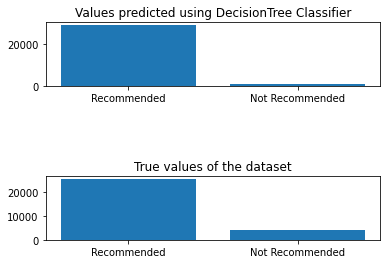

In [ ]:
fig = plt.figure()
fig.clf()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)
a = np.count_nonzero(y_pred==True)
b = np.count_nonzero(y_pred==False)
ax1.bar(["Recommended", "Not Recommended"], [a, b])
ax1.set_title("Values predicted using DecisionTree Classifier")

a = pd.DataFrame(y_true)
true_values = a.recommended.value_counts()[1]
false_values = a.recommended.value_counts()[0]
ax2.set_title("True values of the dataset")
ax2.bar(["Recommended", "Not Recommended"], [true_values, false_values])

In [ ]:
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)


#Configure tuned_parameters
tuned_parameters = {'var_smoothing': [1e-9,1e-7,1e-5]}

#set scoring metric
score = 'f1' 

#Construir el clf con GridSearch
clf = GridSearchCV(GaussianNB(), 
                   param_grid=tuned_parameters, 
                   cv=6,
                   scoring=score)

#Entrenar clf
clf.fit(X_train, y_train)

print("Mejor combinación de parámetros:")
print(clf.best_params_)
 
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0))

Mejor combinación de parámetros:
{'var_smoothing': 1e-09}
              precision    recall  f1-score   support

       False       0.29      0.08      0.13      4319
        True       0.86      0.97      0.91     25681

    accuracy                           0.84     30000
   macro avg       0.58      0.52      0.52     30000
weighted avg       0.78      0.84      0.80     30000



<BarContainer object of 2 artists>

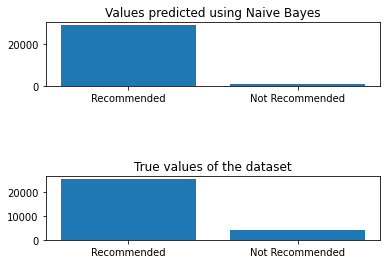

In [ ]:
fig = plt.figure()
fig.clf()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)
a = np.count_nonzero(y_pred==True)
b = np.count_nonzero(y_pred==False)
ax1.bar(["Recommended", "Not Recommended"], [a, b])
ax1.set_title("Values predicted using Naive Bayes")

a = pd.DataFrame(y_true)
true_values = a.recommended.value_counts()[1]
false_values = a.recommended.value_counts()[0]
ax2.set_title("True values of the dataset")
ax2.bar(["Recommended", "Not Recommended"], [true_values, false_values])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)


#Configure tuned_parameters
tuned_parameters = {'n_neighbors': [5,10,15]}

#set scoring metric
score = 'f1' 

#Construir el clf con GridSearch
clf = GridSearchCV(KNeighborsClassifier(), 
                   param_grid=tuned_parameters, 
                   cv=6,
                   scoring=score)

#Entrenar clf
clf.fit(X_train, y_train)

print("Mejor combinación de parámetros:")
print(clf.best_params_)
 
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0))

Mejor combinación de parámetros:
{'n_neighbors': 15}
              precision    recall  f1-score   support

       False       0.30      0.01      0.02      4254
        True       0.86      1.00      0.92     25746

    accuracy                           0.86     30000
   macro avg       0.58      0.50      0.47     30000
weighted avg       0.78      0.86      0.79     30000



<BarContainer object of 2 artists>

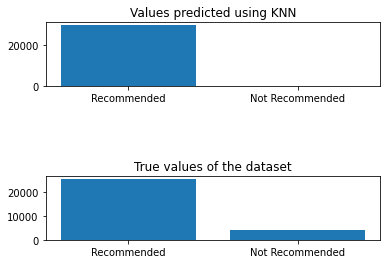

In [ ]:
fig = plt.figure()
fig.clf()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)
a = np.count_nonzero(y_pred==True)
b = np.count_nonzero(y_pred==False)
ax1.bar(["Recommended", "Not Recommended"], [a, b])
ax1.set_title("Values predicted using KNN")

a = pd.DataFrame(y_true)
true_values = a.recommended.value_counts()[1]
false_values = a.recommended.value_counts()[0]
ax2.set_title("True values of the dataset")
ax2.bar(["Recommended", "Not Recommended"], [true_values, false_values])

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

#Construir el clf
clf = SVC()

#Entrenar clf
clf.fit(X_train, y_train)

 
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      4190
        True       0.86      1.00      0.92     25810

    accuracy                           0.86     30000
   macro avg       0.43      0.50      0.46     30000
weighted avg       0.74      0.86      0.80     30000



<BarContainer object of 2 artists>

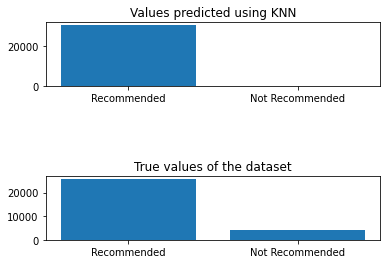

In [ ]:
fig = plt.figure()
fig.clf()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)
a = np.count_nonzero(y_pred==True)
b = np.count_nonzero(y_pred==False)
ax1.bar(["Recommended", "Not Recommended"], [a, b])
ax1.set_title("Values predicted using KNN")

a = pd.DataFrame(y_true)
true_values = a.recommended.value_counts()[1]
false_values = a.recommended.value_counts()[0]
ax2.set_title("True values of the dataset")
ax2.bar(["Recommended", "Not Recommended"], [true_values, false_values])

### Análisis y Conclusiones del Experimento 3

Notamos que de los gráficos anteriores podemos extraer que el Decision Tree posee una leve cantidad de falsos positivos (determinar reviews de no recomendación como reviews de recomendación), lo cual puede ser causado por la baja cantidad de reviews de no recomendación en comparación con la gran cantidad de reviews de recomendación presentes en el dataset.

En conclusión tenemos que se puede predecir con una precisión del 86% si un juego es recomendado en base a las reviews puesto que etiqueta con mayor eficiencia a los juegos recomendados que a los no recomendados.

Para Naive Bayes, se observa una situación similar pero con una precision un poco menor del 84%.


Para los otros clasificadores observados se determinan que no son precisos pues sus valores de `recall` para las falsos recomendados es de 0.

## Experimento en Respuesta Pregunta 4
Dado que se quiere agrupar a los jugadores según las reviews que hacen de juegos, inevitablemente la hay variables importantes que son del tipo str, lo que nos imposibilita usar clustering, por lo que se utiliza reglas de asociacion.

* Procesamiento de datos previo:

In [ ]:
dt_p4 = dt.drop(columns=['X1', 'review_id', 'language', 'review', 'timestamp_created', 'timestamp_updated','votes_helpful', 'votes_funny', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access','author.playtime_last_two_weeks', 'author.last_played'])
dt_p4 = dt_p4.drop(columns=['weighted_vote_score','author.num_games_owned', 'author.num_reviews', 'author.playtime_forever','author.playtime_at_review','app_id'])

In [ ]:
gente = dt_p4[dt_p4['recommended']==True]
gente = gente.drop(columns='recommended').reset_index().drop(columns='index')

In [ ]:
import re
def limpiar(x):
    y = x
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    y = re.sub(regex , ' ', y)
    return y

def limpiar2(x):
    y = x
    regex = '[\\!\\"\\#\\$\\%\\&\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    y = re.sub(regex , ' ', y)
    return y

In [ ]:
gente['app_name']=gente['app_name'].apply(lambda x: limpiar(x))
gente = gente.groupby('author.steamid')['app_name'].apply(list).reset_index().drop(columns='author.steamid')
gente['app_name']=gente['app_name'].apply(lambda x: str(x)[1:-1])
gente=gente['app_name'].apply(lambda x: limpiar2(x))

In [ ]:
gentef.to_csv("/content/drive/MyDrive/Minería/Dataset/Recommended_games_hito_3.csv" ,index=False)

Luego con los Datos listos se sigue trabajando con R.


IMPORTANTE INSERTAR aki LINK AL HTML DE R

### Análisis y conclusiones del Experimento 4


Para este experimento se tiene la problematica de la gran cantidad de datos, por lo que filtrar aquellos reglas que solo tenian un item en su itemset, tenia un costo computacional no alcanzable por lo equipos disponibles, esto genero que a la hora de dar resultados de support estos se vieran disminuidos en base a la consideracion de todas estas reglas con solo un item. Por otro lado es importante notar que existen reglas con un confidence mayor a 0.1 y que además presentan un alto valor de lift mayor a 5 , esto indica que si existe una correlacion positiva entre los items de las reglas, por lo que es posible agrupar a los usuarios en base a grupos de juegos dados por las reglas de asociacion generadas.

## Participación en el Hito 3

- Benjamín Correa: Extensión pregunta 3, análisis de resultados para los experimentos.
- Julián González: Experimento para pregunta 1 y 4
- Camila Pulgar: Realización de experimento para pregunta 2.
- Matías Sothers: Experimento para pregunta 1 y 4.
- Ricardo Valdivia: Extensión pregunta 3, análisis de resultados para los experimentos.


In [ ]:
%%shell
jupyter nbconvert --to html /content/Hito3.ipynb

[NbConvertApp] Converting notebook /content/Hito3.ipynb to html
[NbConvertApp] Writing 648052 bytes to /content/Hito3.html
